<a href="https://colab.research.google.com/github/Harris-giki/Classification_Transformer_Models/blob/main/SwinTransfromer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # For tf.data and preprocessing only.
import keras
from keras import layers
from keras import ops

# Configure the hyperparameters for breast cancer tumor prediction

# Binary classification: two classes (e.g., benign and malignant)
num_classes = 2  # Update from 100 to 2

# Assuming input images are resized appropriately (e.g., 128x128 with 3 channels)
input_shape = (128, 128, 3)  # Update according to your dataset
image_dimension = 128 # Match input shape dimension
# Patch size for Swin Transformer
patch_size = (4, 4)  # Adjust based on the input image size and desired granularity

# Dropout rate
dropout_rate = 0.03

# Transformer-specific settings
num_heads = 8  # Number of attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size

# Attention window
qkv_bias = True
window_size = 4  # Update based on dataset and Swin model capacity
shift_size = 2  # Shift size for windowing

# Derived settings for patch grid
num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

# Training settings
learning_rate = 1e-4  # Adjust learning rate for fine-tuning
batch_size = 32  # Typically smaller for medical datasets
num_epochs = 50  # Adjust based on convergence and dataset size
validation_split = 0.2  # Validation set ratio
weight_decay = 0.0001  # Regularization
label_smoothing = 0.0  # For binary classification, keep label smoothing minimal

# Additional configurations
loss_function = "binary_crossentropy"  # For binary classification
output_activation = "sigmoid"  # Use sigmoid for two-class output



In [ ]:
# Dataset preparation
def load_and_preprocess_dataset(data_dir):
    """
    Load images from directory and split into train, validation, and test sets

    Args:
        data_dir (str): Path to the directory containing subdirectories of classes

    Returns:
        Tuple of (x_train, y_train, x_val, y_val, x_test, y_test)
    """
    # Use tf.keras.utils to load images
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,  # 20% for validation
        subset='both',
        seed=123,
        image_size=(image_dimension, image_dimension),
        batch_size=None  # Important to get full dataset
    )

    # Separate train and validation datasets
    train_dataset, val_dataset = full_dataset

    # Convert to numpy arrays
    x_train, y_train = zip(*list(train_dataset))
    x_val, y_val = zip(*list(val_dataset))

    # Convert to numpy arrays and normalize
    x_train = np.array(x_train) / 255.0
    y_train = np.array(y_train)
    x_val = np.array(x_val) / 255.0
    y_val = np.array(y_val)

    # Create a small test set from validation data
    split_index = len(x_val) // 2
    x_test = x_val[split_index:]
    y_test = y_val[split_index:]
    x_val = x_val[:split_index]
    y_val = y_val[:split_index]

    # One-hot encode labels
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

    return x_train, y_train, x_val, y_val, x_test, y_test

# Path to your dataset (replace with your actual path)
data_dir = "/content/Dataset"  # Update this to your dataset path

# Load and preprocess the dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_and_preprocess_dataset(data_dir)



# Data augmentation function
def augment(x):
    x = tf.image.random_crop(x, size=(image_dimension, image_dimension, 3))
    x = tf.image.random_flip_left_right(x)
    return x

# Create datasets
dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))  # Potential problem here
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)


Found 3664 files belonging to 2 classes.
Using 2932 files for training.
Using 732 files for validation.


In [ ]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x

In [ ]:
class WindowAttention(layers.Layer):
    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [ ]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [ ]:
# Using tf ops since it is only used in tf.data.
def patch_extract(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


In [ ]:
def augment(x):
    x = tf.image.random_crop(x, size=(image_dimension, image_dimension, 3))
    x = tf.image.random_flip_left_right(x)
    return x


dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
# Additional Imports for Metrics
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Modify patch_extract to be a layer
class PatchExtractLayer(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size[0], self.patch_size[1], 1),
            strides=(1, self.patch_size[0], self.patch_size[1], 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (tf.shape(images)[0], patch_num * patch_num, patch_dim))

# Model Construction
def build_swin_transformer_model(input_shape, num_classes):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Patch extraction and embedding
    patch_extract_layer = PatchExtractLayer(patch_size)(inputs)
    patch_embed = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(patch_extract_layer)

    # Swin Transformer blocks
    x = patch_embed
    for _ in range(2):  # You can adjust the number of Transformer blocks
        x = SwinTransformer(
            dim=embed_dim,
            num_patch=(num_patch_x, num_patch_y),
            num_heads=num_heads,
            window_size=window_size,
            shift_size=shift_size,
            num_mlp=num_mlp,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate
        )(x)

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dropout for regularization
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation=output_activation)(x)

    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# Load and preprocess the dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_and_preprocess_dataset(data_dir)

# Create datasets
dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size=batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Build the model
model = build_swin_transformer_model(input_shape, num_classes)

# Compile the model
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

# Model summary
model.summary()

print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

# Train the model
history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)

# Evaluate the model on the test set
results = model.evaluate(dataset_test)
print("Test Metrics:")
for metric_name, value in zip(model.metrics_names, results):
    print(f"{metric_name}: {value}")

# Additional evaluation with metrics like Precision, Recall, F1-Score, and Confusion Matrix
y_pred = model.predict(dataset_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

class_names = [f'class_{i}' for i in range(y_train.shape[1])]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)


Found 3664 files belonging to 2 classes.
Using 2932 files for training.
Using 732 files for validation.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_extract_layer_1                │ (None, 1024, 48)            │               0 │
│ (PatchExtractLayer)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding_1 (PatchEmbedding)   │ (None, 1024, 64)            │          68,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swin_transformer_2 (SwinTransformer) │ (None, 1024, 64)            │          67,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swin_transformer_3 (SwinTransformer) │ (None, 1024, 64)            │          67,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,834 (922.32 KB)

 Trainable params: 169,554 (662.32 KB)

 Non-trainable params: 33,280 (260.00 KB)

y_train shape: (2932, 2)
y_val shape: (366, 2)
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.6546 - loss: 0.6419 - top-5-accuracy: 1.0000 - val_accuracy: 0.6776 - val_loss: 0.6147 - val_top-5-accuracy: 1.0000
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.6844 - loss: 0.6243 - top-5-accuracy: 1.0000 - val_accuracy: 0.6776 - val_loss: 0.6118 - val_top-5-accuracy: 1.0000
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6809 - loss: 0.6214 - top-5-accuracy: 1.0000 - val_accuracy: 0.6776 - val_loss: 0.6082 - val_top-5-accuracy: 1.0000
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6847 - loss: 0.6132 - top-5-accuracy: 1.0000 - val_accuracy: 0.6776 - val_loss: 0.6020 - val_top-5-accuracy: 1.0000
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6832 - loss: 0.6022 - top-5-accuracy: 1.0000 - val_accuracy: 0.6776 - val_loss: 0.6040 - val_top-5-accuracy: 1.0000
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms

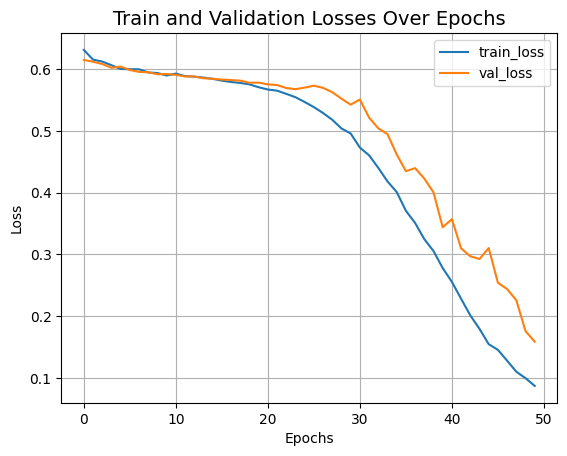

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
loss, accuracy, top_5_accuracy = model.evaluate(dataset_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9630 - loss: 0.1387 - top-5-accuracy: 1.0000
Test loss: 0.14
Test accuracy: 95.9%
Test top 5 accuracy: 100.0%


In [ ]:
import os

def count_images_in_folder(folder_path):
    # Define common image extensions
    image_extensions = [".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"]

    # List and count the image files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.splitext(f)[1].lower() in image_extensions]
    num_images = len(image_files)

    return num_images

# Specify your Google Colab folder path
folder_path = "/content/Dataset/Benign"
folder_path_1 = "/content/Dataset/Malignant"
num_images = count_images_in_folder(folder_path)

num_images_1 = count_images_in_folder(folder_path_1)
print(f"The number of image files in the folder {folder_path} is: {num_images}")
print(f"The number of image files in the folder {folder_path_1} is: {num_images_1}")


The number of image files in the folder /content/Dataset/Benign is: 2520
The number of image files in the folder /content/Dataset/Malignant is: 1144


In [ ]:
num_train_images = len(x_train)
num_val_images = len(x_val)
num_test_images = len(x_test)

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of test images: {num_test_images}")

Number of training images: 2932
Number of validation images: 366
Number of test images: 366
